# Depedencies


In [17]:
# Let's get started with notebook core dependencies
import pandas as pd
import pandera as pa
import geopandas as gpd
import shapely
import numpy as np


import seaborn as sns
import matplotlib as mpl
from lonboard import Map, viz, SolidPolygonLayer, PathLayer

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from geocube.api.core import make_geocube

# Utils functions:


### - Grid factories


In [62]:
from typing import List
from pandera.typing import Index, DataFrame, Series
from pandera.typing.geopandas import GeoDataFrame, GeoSeries
import pandera as pa


def create_grid(
    gdf: None,
    bounds: List[float] | None = None,
    n_cells=10,
    overlap=False,
    crs="EPSG:4326",
):
    """Create square grid that covers a geodataframe area
    or a fixed boundary with x-y coords
    returns: a GeoDataFrame of grid polygons
    see https://james-brennan.github.io/posts/fast_gridding_geopandas/
    """

    import geopandas as gpd
    import shapely

    if bounds != None:
        xmin, ymin, xmax, ymax = bounds
    else:
        xmin, ymin, xmax, ymax = gdf.total_bounds

    # get cell size
    cell_size = (xmax - xmin) / n_cells
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax + cell_size, cell_size):
        for y0 in np.arange(ymin, ymax + cell_size, cell_size):
            x1 = x0 - cell_size
            y1 = y0 + cell_size
            poly = shapely.geometry.box(x0, y0, x1, y1)
            # print (gdf.overlay(poly, how='intersection'))
            grid_cells.append(poly)

    cells = gpd.GeoDataFrame(grid_cells, columns=["geometry"], crs=crs)
    if overlap == True:
        cols = ["grid_id", "geometry", "grid_area"]
        cells = cells.sjoin(gdf, how="inner").drop_duplicates("geometry")
    return cells


def create_hex_grid(gdf=None, bounds=None, n_cells=10, overlap=False, crs="EPSG:4326"):
    """Hexagonal grid over geometry.
    See https://sabrinadchan.github.io/data-blog/building-a-hexagonal-cartogram.html
    """

    from shapely.geometry import Polygon
    import geopandas as gpd

    if bounds != None:
        xmin, ymin, xmax, ymax = bounds
    else:
        xmin, ymin, xmax, ymax = gdf.total_bounds

    unit = (xmax - xmin) / n_cells
    a = np.sin(np.pi / 3)
    cols = np.arange(np.floor(xmin), np.ceil(xmax), 3 * unit)
    rows = np.arange(np.floor(ymin) / a, np.ceil(ymax) / a, unit)

    # print (len(cols))
    hexagons = []
    for x in cols:
        for i, y in enumerate(rows):
            if i % 2 == 0:
                x0 = x
            else:
                x0 = x + 1.5 * unit

            hexagons.append(
                Polygon(
                    [
                        (x0, y * a),
                        (x0 + unit, y * a),
                        (x0 + (1.5 * unit), (y + unit) * a),
                        (x0 + unit, (y + (2 * unit)) * a),
                        (x0, (y + (2 * unit)) * a),
                        (x0 - (0.5 * unit), (y + unit) * a),
                    ]
                )
            )

    grid = gpd.GeoDataFrame({"geometry": hexagons}, crs=crs)
    grid["grid_area"] = grid.area
    grid = grid.reset_index().rename(columns={"index": "grid_id"})
    if overlap == True:
        cols = ["grid_id", "geometry", "grid_area"]
        grid = grid.sjoin(gdf, how="inner").drop_duplicates("geometry")
    return grid


def create_size_based_grid(
    gdf: None,
    bounds: List[float] | None = None,
    size=256,
    overlap=True,
    crs="EPSG:2154",
    epsg: int | None = None,
):
    """Create square grid of fixed size (beware of crs unit) that covers a geodataframe area
    or a fixed boundary with x-y coords
    returns: a GeoDataFrame of grid polygons
    """
    from shapely import Polygon
    from geopandas import GeoDataFrame, sjoin
    from numpy import arange

    gdf_to_merge = gdf
    gdf_to_merge["merge"] = 1
    gdf_merged = gdf_to_merge.dissolve("merge")

    if bounds != None:
        xmin, ymin, xmax, ymax = bounds
    else:
        xmin, ymin, xmax, ymax = gdf_merged.total_bounds

    cols = list(arange(xmin, xmax + size, size))
    rows = list(arange(ymin, ymax + size, size))

    polygons = []
    for x in cols[:-1]:
        for y in rows[:-1]:
            polygons.append(
                Polygon(
                    [
                        (x, y),
                        (x + size - 1, y),
                        (x + size - 1, y + size - 1),
                        (x, y + size - 1),
                    ]
                )
            )
    if epsg != None:
        grid = GeoDataFrame({"geometry": polygons}, epsg=epsg)
    else:
        grid = GeoDataFrame({"geometry": polygons}, crs=crs)
    if overlap == True:
        grid = sjoin(grid, gdf_merged, how="inner", predicate="within")
    grid.insert(1, "id", range(1, 1 + len(grid)))
    grid = grid.reset_index()
    grid = grid[["id", "geometry"]]
    return grid

### - Geoportail webservices


In [19]:
from typing import Union, List

Num = Union[int, float]


def stringify_bbox(bounds: List[Num]) -> str:
    """
    Receive bounding box as a list and return it as a formatted string
    """
    xmin, ymin, xmax, ymax = bounds
    return f"{xmin},{ymin},{xmax},{ymax}"


def get_tile_url(
    base_url="https://wxs.ign.fr/ortho/geoportail/r/wms",
    layer_name="ORTHOIMAGERY.ORTHOPHOTOS.BDORTHO",
    bbox="785802.3085941937752,6336806.404346071184,786208.1537742479704,6337311.468582574278",
    size=256,
) -> str:
    """
    Helper to format geoservices web expert URL

    Args:
      base_url:  "https://wxs.ign.fr/ortho/geoportail/r/wms" | "https://wxs.ign.fr/orthohisto/geoportail/r/wms"
      layer_name: layer service; see IGN geoservices doc for details:
              - Ortho https://geoservices.ign.fr/services-web-experts-ortho
              - Orthohisto https://geoservices.ign.fr/services-web-experts-orthohisto
      bbox: bounding box param, see `stringify_bbox` function to get formatted parrams from geopandas bounding box

    Returns:
      Formatted URI with params
    """
    params = f"SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&BBOX={bbox}&CRS=EPSG:2154&WIDTH={size}&HEIGHT={size}&LAYERS={layer_name}&STYLES=&FORMAT=image/geotiff&DPI=72&MAP_RESOLUTION=72&FORMAT_OPTIONS=dpi:72"
    return f"{base_url}?{params}"


def download_image_from_url(
    url=None, index=None, out_path="./downloads/tiles", default_images_folder="default"
):
    import time
    from urllib.parse import urlparse, parse_qs
    import requests

    if url is None:
        raise ValueError("url param s required")
    t0 = time.time()
    parsed_url = urlparse(url)
    layer_param = parse_qs(parsed_url.query)["LAYERS"][0]
    bbox_param = parse_qs(parsed_url.query)["BBOX"][0]
    bbox_tuple = tuple(map(float, bbox_param.split(",")))

    if layer_param in [
        "ORTHOIMAGERY.ORTHOPHOTOS.IRC",
        "ORTHOIMAGERY.ORTHOPHOTOS.IRC-EXPRESS.2021",
    ]:
        out_dir = f"{out_path}/irc"
    elif layer_param in [
        "ORTHOIMAGERY.ORTHOPHOTOS.BDORTHO",
        "ORTHOIMAGERY.ORTHOPHOTOS.ORTHO-EXPRESS.2021",
    ]:
        out_dir = f"{out_path}/ortho"
    else:
        out_dir = f"{out_path}/{default_images_folder}"

    try:
        r = requests.get(url)
        if r.status_code == 200:
            if index is None:
                image_path = f"{out_dir}/image_{hash(bbox_tuple)}.tiff"
            else:
                image_path = f"{out_dir}/image_{index}.tiff"
            with open(image_path, "wb") as f:
                f.write(r.content)
            return (image_path, time.time() - t0, url)
        else:
            return (None, None, url)
    except Exception as e:
        print("Exception in download_url():", e)

### - Plotting


In [34]:
def plot_trio(ortho, irc, mask):
    import rasterio
    import matplotlib.pyplot as plt

    # Paths to the three raster images
    image_paths = [ortho, irc, mask]

    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Loop through the image paths and plot each image
    for i, image_path in enumerate(image_paths):
        with rasterio.open(image_path) as src:
            # Read the image data
            img_data = src.read()

            # Plot the image using imshow
            axes[i].imshow(
                img_data.transpose((1, 2, 0))
            )  # Transpose to (height, width, bands) for RGB images
            axes[i].set_title(f"Image {i + 1}")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


def plot_trio_from_index(index, dataset_path="./datasets"):
    import rasterio
    import matplotlib.pyplot as plt

    # Paths to the three raster images
    image_paths = [
        f"{dataset_path}/images/ortho/image_{index}.tiff",
        f"{dataset_path}/images/irc/image_{index}.tiff",
        f"{dataset_path}/masks/mask_{index}.tif",
    ]

    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Loop through the image paths and plot each image
    for i, image_path in enumerate(image_paths):
        with rasterio.open(image_path) as src:
            # Read the image data
            img_data = src.read()

            # Plot the image using imshow
            axes[i].imshow(
                img_data.transpose((1, 2, 0))
            )  # Transpose to (height, width, bands) for RGB images
            axes[i].set_title(f"Image {i + 1}")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


def plot_area_and_grid(area_gdf, grid_gdf, title="Geoplot 1"):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(14, 7))
    area_gdf.plot(ec="gray", fc="none", figsize=(10, 10), ax=ax)
    grid_gdf.plot(fc="none", ec="black", ax=ax)
    ax.set_title(title)

### - Data transformation utils


In [21]:
def labels_to_mask_with_geocube(
    gdf, index, size=256, resolution=1, out_path="./datasets/masks"
):
    from geocube.api.core import make_geocube

    # Using GeoCube to rasterize the Vector
    mask_geocube = make_geocube(
        vector_data=gdf,
        measurements=["eunis_niv1_label"],
        resolution=(-resolution, resolution),
        fill=0,
    )

    # Save raster census raster
    mask_geocube.rio.to_raster(f"{out_path}/mask_{index}.tif")
    return f"{out_path}/mask_{index}.tif"


# TODO: refact this function to allow multithread processing
def create_4_band_training_raster(gdf, index, out_path="./datasets/images/training"):
    import rasterio
    from rasterio.plot import reshape_as_raster, reshape_as_image
    import os

    if not os.path.exists(out_path):
        os.makedirs(out_path)

    (minx, miny, maxx, maxy) = gdf.total_bounds
    ortho_url = get_tile_url(
        base_url="https://wxs.ign.fr/orthohisto/geoportail/r/wms",
        layer_name="ORTHOIMAGERY.ORTHOPHOTOS.ORTHO-EXPRESS.2021",
        bbox=f"{minx},{miny},{maxx},{maxy}",
    )
    irc_url = get_tile_url(
        base_url="https://wxs.ign.fr/orthohisto/geoportail/r/wms",
        layer_name="ORTHOIMAGERY.ORTHOPHOTOS.IRC-EXPRESS.2021",
        bbox=f"{minx},{miny},{maxx},{maxy}",
    )
    (ortho_path, ortho_time, d_ortho_url) = download_image_from_url(
        url=ortho_url, index=index, out_path="./datasets/images"
    )
    (irc_path, irc_time, d_irc_url) = download_image_from_url(
        url=irc_url, index=index, out_path="./datasets/images"
    )

    train_path = f"{out_path}/image_{index}.tif"
    # Open the RGB image
    with rasterio.open(ortho_path) as rgb_src:
        # Read RGB data and metadata
        rgb_data = rgb_src.read()
        metadata = rgb_src.meta.copy()

    # Open the nir image
    with rasterio.open(irc_path) as infrared_src:
        # Read infrared data
        infrared_data = infrared_src.read(2)

    # Combine RGB and infrared data into a four-band array
    four_band_data = [rgb_data[0], rgb_data[1], rgb_data[2], infrared_data]
    # Update metadata for the new four-band raster
    metadata.update(count=4)

    # Create a new raster file and write the four-band data
    with rasterio.open(train_path, "w", **metadata) as dst:
        for i, band in enumerate(four_band_data, start=1):
            dst.write(band, i)

    return (ortho_path, irc_path, train_path)

# Data preparation


### Remote source files links


In [107]:
# Liens data.montpellier3m.fr
poles_zonage_3m_url = "https://data.montpellier3m.fr/sites/default/files/ressources/MMM_MMM_PolesZonage_0.zip"

# cadastre archive contains multiple shapefiles (hydro, bati...)
cadastre_3m_url = (
    "https://data.montpellier3m.fr/sites/default/files/ressources/MMM_MMM_Cadastre.zip"
)
contour_3m_url = (
    "https://data.montpellier3m.fr/sites/default/files/ressources/MMM_MMM_Contours.zip"
)
occsol_3m_url = (
    "https://data.montpellier3m.fr/sites/default/files/ressources/MMM_MMM_OccupSol.zip"
)
vegetation_fine_3m = (
    "https://data.montpellier3m.fr/sites/default/files/ressources/MMM_MMM_VegFine.zip"
)


def download_extract_delete_remote_archives(archives_urls, out_folder="./data/3m"):
    import os
    import requests
    import shutil
    import zipfile

    if not os.path.exists(out_folder):
        os.makedirs(out_folder)

    # Download the archive ; to do serialize this
    for index, url in enumerate(archives_urls):
        response = requests.get(url)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            # Get the filename from the response headers
            content_disposition = response.headers.get("Content-Disposition")
            if content_disposition:
                filename = content_disposition.split("filename=")[1].strip('"')
            else:
                # If no filename is provided in the headers, the endtrail of url
                filename = url.split("/")[-1]

            # Create the path for the downloaded archive
            archive_path = os.path.join(
                out_folder, filename
            )  # Adjust for different archive types

            # Save the downloaded content to the archive file
            with open(archive_path, "wb") as archive_file:
                archive_file.write(response.content)

            # Extract the archive
            extract_folder = os.path.join(
                out_folder, os.path.splitext(os.path.basename(archive_path))[0]
            )
            with zipfile.ZipFile(archive_path, "r") as zip_ref:
                zip_ref.extractall(extract_folder)

            # Optionally, delete the downloaded archive
            os.remove(archive_path)

            print(
                f"Archive downloaded, extracted, and deleted successfully to: {extract_folder}"
            )
        else:
            print(f"Failed to download archive. Status code: {response.status_code}")

In [ ]:
# Download resource files
download_extract_delete_remote_archives(
    archives_urls=[poles_zonage_3m_url, contour_3m_url, occsol_3m_url, cadastre_3m_url],
    out_folder="./data/test",
)

In [22]:
# Get administrative bondaries for study area (3Md)
boundaries = gpd.read_file(
    "./data/3m/MMM_MMM_PolesZonage/MMM_MMM_PolesZonage.shp", crs="EPSG:2154"
)

#### (optionnal) create parquet files for big geospatial data (>100Mb) to speed data reads + transformations


In [ ]:
# Landcover (occsol) to parquet file
occsol_gdf = gpd.read_file(
    "./data/3m/MMM_MMM_OccupSol/MMM_MMM_OccupSol.shp", crs="EPSG:2154"
)
occsol_gdf.to_parquet("./data/parquet/clc_3m.parquet")

In [24]:
# occsol dataframe preparation
clc_3m_gdf = gpd.read_parquet("./data/parquet/clc_3m.parquet")
clc_3m_gdf.to_crs("EPSG:2154", inplace=True)

In [ ]:
# Create a grid for SA entire coverage
grid_3m = create_size_based_grid(gdf=clc_3m_gdf, overlap=True)
grid_3m["size"] = grid_3m["geometry"].length / 4
grid_3m.head()

(737432.699999982, 799103.0999999819, 6242629.600002656, 6304581.600002656)

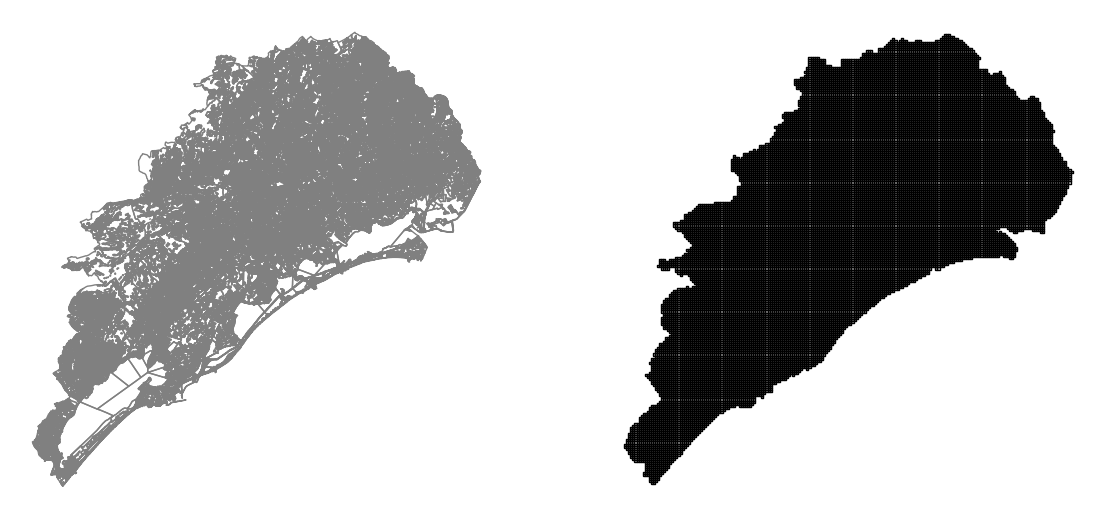

In [272]:
# Plot 3M grid and landcover layer

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
axs = ax.flat
clc_3m_gdf.plot(ec="gray", fc="none", figsize=(10, 10), ax=axs[0])
grid_3m.plot(fc="none", ec="black", ax=axs[1])
axs[0].axis("off")
axs[1].axis("off")

In [26]:
# Collect landcover fields of interest
clc_21_niv4_3m_gdf = clc_3m_gdf[
    ["c2021_niv1", "lib21_niv1", "c2021_niv4", "lib21_niv4", "geometry"]
]
clc_21_niv4_3m_gdf.head(25)

,c2021_niv1,lib21_niv1,c2021_niv4,lib21_niv4,geometry
0,7,Espaces naturels non boisés,7820,Marais maritimes,"POLYGON ((742269.535 6248240.552, 742250.300 6..."
1,5,Espaces agricoles,5121,Espaces libres urbains,"POLYGON ((783953.823 6291883.226, 783966.394 6..."
2,5,Espaces agricoles,5121,Espaces libres urbains,"POLYGON ((781205.235 6284279.038, 781260.980 6..."
3,8,Eau,8220,Plans d'eau et lagunes littorales,"POLYGON ((780145.613 6277024.020, 780063.022 6..."
4,5,Espaces agricoles,5121,Espaces libres urbains,"POLYGON ((758879.856 6272901.789, 758892.140 6..."
5,5,Espaces agricoles,5221,Vergers en exploitation,"POLYGON ((785921.828 6282821.166, 785954.456 6..."
6,5,Espaces agricoles,5221,Vergers en exploitation,"POLYGON ((760408.100 6274080.600, 760403.112 6..."
7,6,Espaces boisés,6110,Feuillus mésophiles dominants,"POLYGON ((744068.463 6254143.414, 744011.575 6..."
8,8,Eau,8300,"Mer, océan et estuaires","POLYGON ((757311.864 6255758.885, 757309.379 6..."
9,5,Espaces agricoles,5140,Prairies,"POLYGON ((758260.437 6271489.652, 758257.173 6..."


In [27]:
## Add CLC:EUNIS mapping + Stats


def letter_to_ordinal(letter: str, case="up"):
    try:
        if case == "up":
            return ord(letter) - 64
        elif case == "down":
            return ord(letter) - 96
        else:
            return None
    except Exception as err:
        print(f"Unexpected {err=}, {type(err)=}")
        raise


eunis_mapping_df = pd.read_excel("./data_ns/CORINE_LAND_COVER_MONTPELLIER.xlsx")
eunis_mapping_df["eunis_niv1_label"] = eunis_mapping_df.apply(
    lambda x: letter_to_ordinal(x["CODE_EUNIS_niv1"]), axis=1
)
map_df = eunis_mapping_df[["c2021_niv4", "eunis_niv1_label"]]
gdf = clc_21_niv4_3m_gdf.merge(eunis_mapping_df, on="c2021_niv4", suffixes=("", "_map"))
eunis_niv1_3m_gdf = gdf[
    ["geometry", "eunis_niv1_label", "CODE_EUNIS_niv1", "c2021_niv4", "c2021_niv1"]
]
eunis_niv1_3m_gdf["area_ha"] = eunis_niv1_3m_gdf["geometry"].area / 10**4
eunis_niv1_3m_gdf.reset_index()
eunis_niv1_3m_gdf.head()

/Users/gaetan/.pyenv/versions/3.10.12/envs/3m-ai-dataprep-env/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,geometry,eunis_niv1_label,CODE_EUNIS_niv1,c2021_niv4,c2021_niv1,area_ha
0,"POLYGON ((742269.535 6248240.552, 742250.300 6...",2,B,7820,7,0.005211
1,"POLYGON ((767352.525 6268848.993, 767361.873 6...",2,B,7820,7,0.113166
2,"POLYGON ((763211.640 6263361.392, 763236.168 6...",2,B,7820,7,1.269219
3,"POLYGON ((766041.394 6268039.741, 766037.300 6...",2,B,7820,7,5.224858
4,"POLYGON ((768466.461 6265323.085, 768466.452 6...",2,B,7820,7,0.041889


In [28]:
# Export Landcover classes
df = eunis_niv1_3m_gdf.groupby(
    ["eunis_niv1_label", "CODE_EUNIS_niv1", "c2021_niv4", "c2021_niv1"]
)["eunis_niv1_label"].count()
df.to_csv("./export/eunis1-clc4_2021_3m.csv")
df.to_excel("./export/eunis1-clc4_2021_3m.xlsx")
df

eunis_niv1_label  CODE_EUNIS_niv1  c2021_niv4  c2021_niv1
1                 A                8300        8             109
2                 B                7400        7              57
                                   7820        7             152
                                   8220        8             300
3                 C                7810        7              30
                                                            ... 
10                J                4222        4              33
                                   5122        5               2
24                X                4111        4             496
                                   4121        4              33
                                   5111        5             104
Name: eunis_niv1_label, Length: 80, dtype: int64

In [ ]:
# Eunis classes metric by city - Excel exporter
boundaries = gpd.read_file(
    "./data/3m/MMM_MMM_PolesZonage/MMM_MMM_PolesZonage.shp", crs="EPSG:2154"
)


def plot_area_and_grid(area_gdf, grid_gdf, title="Geoplot 1"):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(14, 7))
    area_gdf.plot(ec="gray", fc="none", figsize=(10, 10), ax=ax)
    grid_gdf.plot(fc="none", ec="black", ax=ax)
    ax.set_title(title)


with pd.ExcelWriter("./export/eunis1-clc4_2021_3m_classes.xlsx") as local_writer:
    for row in boundaries.itertuples():
        clipped = eunis_niv1_3m_gdf.clip(row.geometry)
        clipped_2154 = clipped.to_crs("EPSG:2154")
        grid = create_size_based_grid(gdf=clipped_2154, overlap=True)
        plot_area_and_grid(clipped_2154, grid, row.nom)
        local_summary_df = clipped_2154.groupby(
            ["eunis_niv1_label", "CODE_EUNIS_niv1"]
        )["area_ha"].sum()
        local_summary_df.to_excel(
            local_writer, sheet_name=f"N={len(grid)} -> {row.nom}"
        )

with pd.ExcelWriter("./export/eunis1-clc4_2021_3m.xlsx") as global_writer:
    global_summary_df = eunis_niv1_3m_gdf.groupby(
        ["eunis_niv1_label", "CODE_EUNIS_niv1"]
    )["area_ha"].sum()
    global_summary_df.to_excel(global_writer)

In [85]:
boundaries = gpd.read_file(
    "./data/3m/MMM_MMM_PolesZonage/MMM_MMM_PolesZonage.shp", crs="EPSG:2154"
)
cities = [row.nom for row in boundaries.itertuples()]
print(cities)

['CASTELNAU-LE-LEZ', 'MONTPELLIER', 'PEROLS', 'CASTRIES', 'BAILLARGUES', 'BEAULIEU', 'COURNONSEC', 'JACOU', 'CLAPIERS', 'COURNONTERRAL', 'LAVERUNE', 'FABREGUES', 'RESTINCLIERES', 'GRABELS', 'SAINT-BRES', 'JUVIGNAC', 'VENDARGUES', 'LATTES', 'LE CRES', 'MONTFERRIER-SUR-LEZ', 'MONTAUD', 'SAINT-GENIES-DES-MOURGUES', 'MURVIEL-LES-MONTPELLIER', 'SAINT-DREZERY', 'PIGNAN', 'SAUSSAN', 'PRADES-LE-LEZ', 'SUSSARGUES', "SAINT-GEORGES-D'ORQUES", 'SAINT-JEAN-DE-VEDAS', 'VILLENEUVE-LES-MAGUELONE']


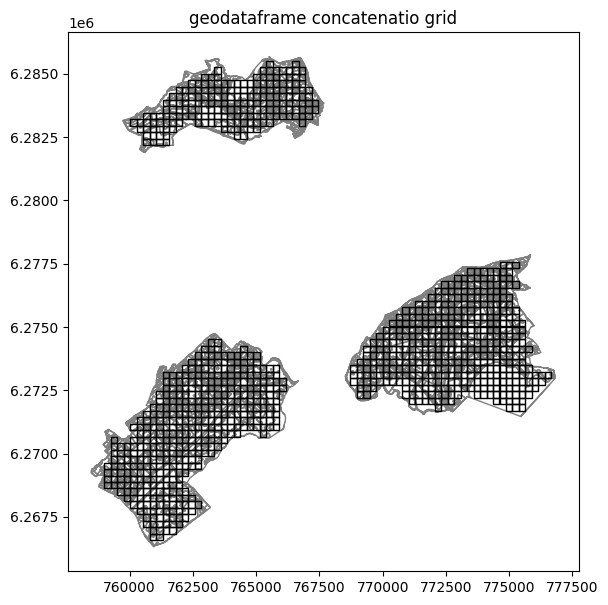

In [92]:
frames = []
for row in boundaries.itertuples():
    if row.nom in ["LATTES", "FABREGUES", "GRABELS"]:
        clipped = eunis_niv1_3m_gdf.clip(row.geometry)
        frames.append(clipped.to_crs("EPSG:2154"))
result = pd.concat(frames, ignore_index=True)
grid = create_size_based_grid(gdf=result, overlap=True)
plot_area_and_grid(result, grid, "geodataframe concatenatio grid")

In [93]:
len(grid)

1037

## Training data preparation utils


In [ ]:
for index, geometry in grid["geometry"].items():
    clipped = eunis_niv1_3m_gdf.clip(geometry)
    mask_path = labels_to_mask_with_geocube(clipped, index)
    (ortho_path, irc_path, train_path) = create_4_band_training_raster(clipped, index)

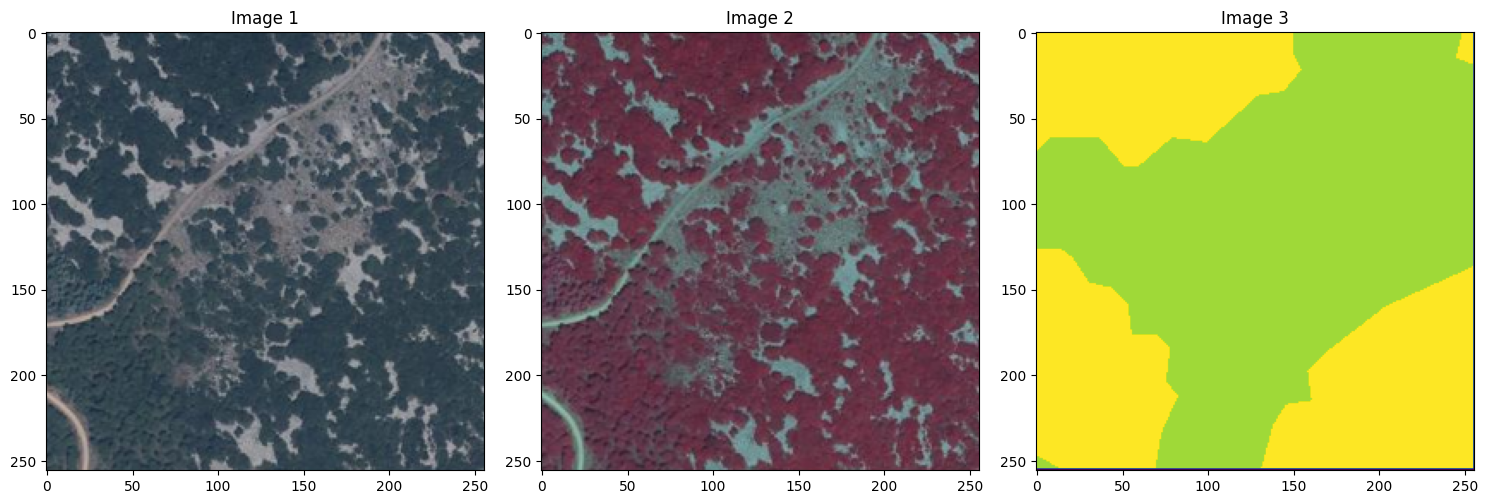

In [89]:
plot_trio_from_index(4)

## Generate training data in HDF5


In [90]:
def save_h5_dataset(images, masks, filename):
    import h5py
    import os

    # ---- Create h5 file
    with h5py.File(filename, "w") as f:
        f.create_dataset("images", data=images)
        f.create_dataset("masks", data=masks)

    # ---- done
    size = os.path.getsize(filename) / (1024 * 1024)
    print(
        "Dataset : {:24s}  shape : {:22s} size : {:6.1f} Mo   (saved)".format(
            filename, str(images.shape), size
        )
    )

In [91]:
IMAGES_DIR = "./datasets/images/training"
MASKS_DIR = "./datasets/masks"
from PIL import Image
from pathlib import Path
import os
import numpy as np
import rasterio
from rasterio.plot import reshape_as_image


def raster_to_nparray(raster):
    pass


image_names = []
for file in Path(IMAGES_DIR).glob("*.tif"):
    fileName = Path(file).stem + ".tif"
    image_names.append(os.path.join(IMAGES_DIR, fileName))
image_names.sort()

mask_names = []
for file in Path(MASKS_DIR).glob("*.tif"):
    fileName = Path(file).stem + ".tif"
    mask_names.append(os.path.join(MASKS_DIR, fileName))
mask_names.sort()

images = [np.asarray(Image.open(image)) for image in image_names]
masks = [reshape_as_image(rasterio.open(mask).read()) for mask in mask_names]
image_dataset = np.array(images)
mask_dataset = np.array(masks)

print(image_dataset.shape)
print(mask_dataset.shape)

(37, 256, 256, 4)
(38, 256, 256, 1)


In [84]:
H5_FILE = "./h5/training_01.h5"
save_h5_dataset(mask_dataset, image_dataset, H5_FILE)

Dataset : ./h5/training_01.h5       shape : (6, 256, 256, 1)       size :    4.5 Mo   (saved)


## Test - Sandoxes


In [65]:
cell = grid.iloc[300:301]
print(cell.crs)
print(eunis_niv1_3m_gdf.crs)
clip_occsol = eunis_niv1_3m_gdf.clip(cell)
cell.head()

mask_geocube = make_geocube(
    vector_data=clip_occsol,
    measurements=["eunis_niv1_label"],
    resolution=(-1, 1),
    fill=0,
)
mask_cell = make_geocube(
    vector_data=cell,
    measurements=["id"],
    resolution=(-1, 1),
    fill=0,
)
mask_cell

EPSG:2154
EPSG:2154


<xarray.Dataset>
Dimensions:      (y: 256, x: 256)
Coordinates:
  * y            (y) float64 6.274e+06 6.274e+06 ... 6.274e+06 6.274e+06
  * x            (x) float64 7.626e+05 7.626e+05 ... 7.628e+05 7.628e+05
    spatial_ref  int64 0
Data variables:
    id           (y, x) float64 0.0 301.0 301.0 301.0 301.0 ... 0.0 0.0 0.0 0.0